In [1]:
# Task: Now is your turn to apply everything you learned in this lesson to create your own CNN to classify images of flowers.

In [2]:
# imports

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [3]:
# TensorFlow imports

import tensorflow as tf

In [4]:
import keras
from keras import layers

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
file_data = tf.keras.utils.get_file(origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(file_data), 'flower_photos')

228813984/228813984 [==============================] - 3s 0us/step


In [7]:
print(file_data)

/root/.keras/datasets/flower_photos.tgz


In [8]:
print(base_dir)

/root/.keras/datasets/flower_photos


In [9]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [10]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))

    # had issues with shutil.move, so used shutil.copy instead
    shutil.copy(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))

    # had issues with shutil.move, so used shutil.copy instead
    shutil.copy(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [11]:
print(base_dir)

/root/.keras/datasets/flower_photos


In [12]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [13]:
# Image size would be 150 x 150
# Batch size would be 100
# random 45 degree rotation
# random zoom of up to 50%
# random horizontal flip
# width shift of 0.15
# height shift of 0.15

In [14]:
train_image = ImageDataGenerator(
              rescale = 1./255,
              rotation_range = 45,
              zoom_range = 0.5,
              horizontal_flip = True,
              width_shift_range = 0.15,
              height_shift_range = 0.15
)

In [15]:
train_data = train_image.flow_from_directory(
                                                batch_size=100,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(150,150),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


In [16]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

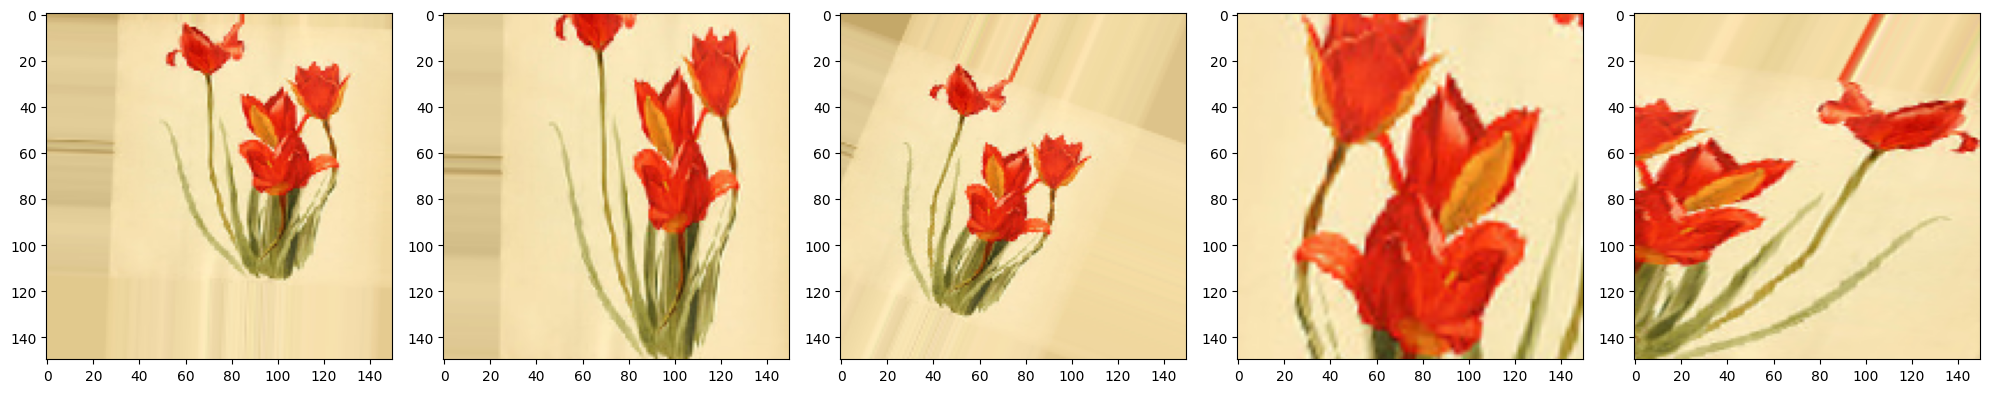

In [17]:
aug_image = [train_data[0][0][0] for i in range(5)]
plotImages(aug_image)

In [18]:
# for validation set

val_image = ImageDataGenerator(rescale=1./255)

val_data = val_image.flow_from_directory(batch_size = 100, directory = val_dir,
                                         shuffle=False,
                                         target_size=(150,150),
                                         class_mode="sparse")

Found 735 images belonging to 5 classes.


In [19]:
from tensorflow.python.ops.gen_nn_ops import Conv2D
# creating the convolutional neural network, softmax for probabilities, flatten layer, dense layer, CNN, maxpooling

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation="relu"))

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation="softmax"))

In [20]:
# compile the model

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [22]:
# will train model for 100 epochs
# need to use .fit_generator, instead of .fit because of augmentation: https://stackoverflow.com/questions/65885923/can-we-use-model-fit-only-instead-of-model-fit-generator#:~:text=fit%20is%20used%20when%20the,augmentation%20needs%20to%20be%20applied.

train_model = model.fit_generator(train_data, steps_per_epoch=np.ceil(train_data.n / 100),
                                  epochs=100,
                                  validation_data = val_data, validation_steps=np.ceil(val_data.n/ 100.0))

<ipython-input-22-f0c9b725a80c>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  train_model = model.fit_generator(train_data, steps_per_epoch=np.ceil(train_data.n / 100),


Epoch 1/100
30/30 [==============================] - 42s 913ms/step - loss: 1.5338 - accuracy: 0.3066 - val_loss: 1.3503 - val_accuracy: 0.3918
Epoch 2/100
30/30 [==============================] - 28s 943ms/step - loss: 1.3308 - accuracy: 0.4232 - val_loss: 1.2755 - val_accuracy: 0.4367
Epoch 3/100
30/30 [==============================] - 28s 953ms/step - loss: 1.2056 - accuracy: 0.4698 - val_loss: 1.1115 - val_accuracy: 0.5211
Epoch 4/100
30/30 [==============================] - 30s 1s/step - loss: 1.0940 - accuracy: 0.5455 - val_loss: 1.1063 - val_accuracy: 0.5279
Epoch 5/100
30/30 [==============================] - 27s 907ms/step - loss: 1.0424 - accuracy: 0.5918 - val_loss: 1.0344 - val_accuracy: 0.5823
Epoch 6/100
30/30 [==============================] - 27s 915ms/step - loss: 0.9942 - accuracy: 0.6051 - val_loss: 0.9288 - val_accuracy: 0.6299
Epoch 7/100
30/30 [==============================] - 27s 915ms/step - loss: 0.9650 - accuracy: 0.6133 - val_loss: 0.8412 - val_accuracy: 0.

In [23]:
print((train_data.n))

2935


In [24]:
# Training data accuracy is almost 87% and validation data accuracy is 80%.

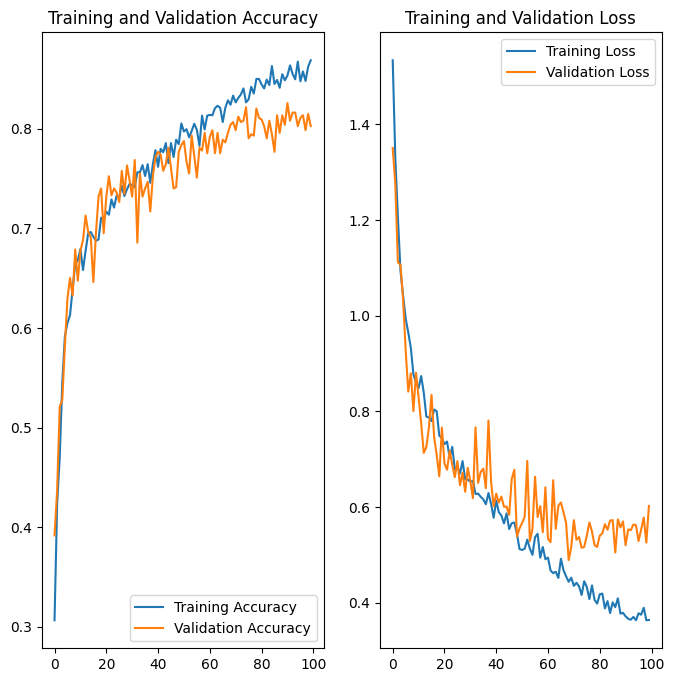

In [27]:
# Displaying graphs from previous lab to check if model is overfitting

acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()